<a href="https://colab.research.google.com/github/SnehaVenkatesh19/Credit-Card-Analysis/blob/main/CreditCard_RFM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Upload the raw transactional dataset
from google.colab import files
uploaded = files.upload()

Saving credit_card_transactions.csv to credit_card_transactions.csv


In [2]:
#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import timedelta

# Load dataset
df = pd.read_csv("credit_card_transactions.csv")



In [3]:
#  Preprocess
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
snapshot_date = df['trans_date_trans_time'].max() + timedelta(days=1)



In [4]:
#  RFM Table
rfm = df.groupby('cc_num').agg({
    'trans_date_trans_time': lambda x: (snapshot_date - x.max()).days,   # Recency
    'trans_num': 'count',      # Frequency
    'amt': 'sum'               # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head(2)


,CustomerID,Recency,Frequency,Monetary
0,60416207185,1,1518,85043.47
1,60422928733,1,1531,105640.20


In [5]:
#  Remove outliers (optional but good for clustering)
q_low, q_high = rfm['Monetary'].quantile([0.01, 0.99])
rfm = rfm[(rfm['Monetary'] >= q_low) & (rfm['Monetary'] <= q_high)]



In [6]:
#  Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])



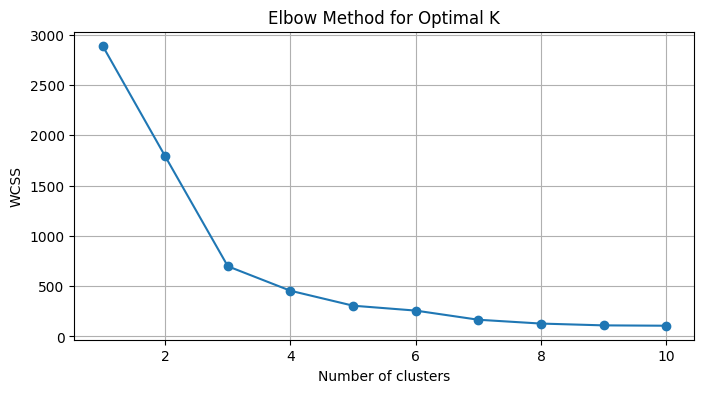

In [7]:
#  Elbow Method to find optimal clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()



In [8]:
#  KMeans Clustering
k = 4  # Based on Elbow curve
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)



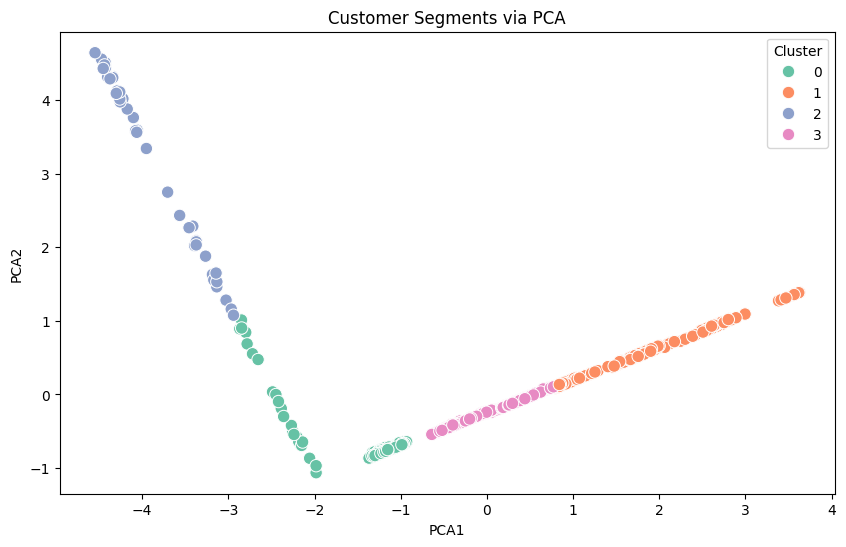

In [9]:
#  Visualize Clusters with PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80)
plt.title("Customer Segments via PCA")
plt.show()



In [10]:
#  Cluster Profiling
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print("Cluster Summary:")
print(cluster_profile)



Cluster Summary:
        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          10.5     465.3   35122.9   245
1           1.0    2240.4  157189.4   306
2         380.6      10.5    6383.1    41
3           1.1    1255.7   84671.4   371


In [12]:
#  Strategy Ideas
for c in sorted(rfm['Cluster'].unique()):
    print(f"\n Cluster {c} strategy:")
    r = rfm[rfm['Cluster'] == c]
    if r['Monetary'].mean() > rfm['Monetary'].mean():
        print(" High-value customers — reward with loyalty programs.")
    elif r['Recency'].mean() > rfm['Recency'].mean():
        print(" At-risk users — send reactivation offers.")
    elif r['Frequency'].mean() < rfm['Frequency'].mean():
        print(" Low frequency — cross-sell or improve retention.")
    else:
        print(" Nurture early adopters — promote onboarding.")

# Optional: Save results
# rfm.to_csv("rfm_segmented.csv", index=False)



 Cluster 0 strategy:
 Low frequency — cross-sell or improve retention.

 Cluster 1 strategy:
 High-value customers — reward with loyalty programs.

 Cluster 2 strategy:
 At-risk users — send reactivation offers.

 Cluster 3 strategy:
 Low frequency — cross-sell or improve retention.
